# Fully Connected Experiments


## 1. Setup

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import semitorch

from collections import OrderedDict
from IPython import display
from statistics import quantiles
from torch.utils.data import DataLoader
from tqdm.notebook import trange

data_path = os.path.abspath("./data" if os.path.isdir("./data") else "../data")
device = "cuda" if torch.cuda.is_available() else "cpu"


def split_dataset(dataset: torch.utils.data.Dataset):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    return torch.utils.data.random_split(dataset, [train_size, test_size])

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.7
[Taichi] Starting on arch=cuda


### Load iris data
[https://www.kaggle.com/datasets/uciml/iris](https://www.kaggle.com/datasets/uciml/iris)

In [2]:
iris_df = pd.read_csv(
    os.path.join(data_path, "iris.csv"), index_col=0, dtype={"Species": "string"}
)
iris_x = torch.Tensor(iris_df.iloc[:, [0, 1, 2, 3]].to_numpy()).to(device)

iris_y = (
    iris_df["Species"]
    .map({
        "Iris-setosa": 0,
        "Iris-versicolor": 1,
        "Iris-virginica": 2,
    }).to_numpy()
)
iris_y = torch.Tensor(iris_y).to(torch.int64).to(device)
print(f"Iris dataset: input features = {iris_x.shape[1]}, "
      f"classes = {torch.unique(iris_y).shape[0]}, "
      f"samples = {len(iris_y)}")

# normalize
torch.nn.functional.normalize(iris_x, dim=0, out=iris_x)

iris_train, iris_test = split_dataset(torch.utils.data.TensorDataset(iris_x, iris_y))

Iris dataset: input features = 4, classes = 3, samples = 150


tensor([[0.0706, 0.0927, 0.0275, 0.0115],
        [0.0678, 0.0794, 0.0275, 0.0115],
        [0.0650, 0.0847, 0.0256, 0.0115],
        [0.0636, 0.0821, 0.0295, 0.0115],
        [0.0692, 0.0953, 0.0275, 0.0115],
        [0.0747, 0.1032, 0.0334, 0.0230],
        [0.0636, 0.0900, 0.0275, 0.0173],
        [0.0692, 0.0900, 0.0295, 0.0115],
        [0.0609, 0.0768, 0.0275, 0.0115],
        [0.0678, 0.0821, 0.0295, 0.0058],
        [0.0747, 0.0979, 0.0295, 0.0115],
        [0.0664, 0.0900, 0.0315, 0.0115],
        [0.0664, 0.0794, 0.0275, 0.0058],
        [0.0595, 0.0794, 0.0216, 0.0058],
        [0.0802, 0.1059, 0.0236, 0.0115],
        [0.0789, 0.1165, 0.0295, 0.0230],
        [0.0747, 0.1032, 0.0256, 0.0230],
        [0.0706, 0.0927, 0.0275, 0.0173],
        [0.0789, 0.1006, 0.0334, 0.0173],
        [0.0706, 0.1006, 0.0295, 0.0173],
        [0.0747, 0.0900, 0.0334, 0.0115],
        [0.0706, 0.0979, 0.0295, 0.0230],
        [0.0636, 0.0953, 0.0197, 0.0115],
        [0.0706, 0.0874, 0.0334, 0

### Load heart disease data

[https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset)

In [3]:
heart_df = pd.read_csv(os.path.join(data_path, "heart.csv"))
heart_x = (torch.Tensor(heart_df.iloc[:, range(13)].to_numpy()).to(torch.float32).to(device))
heart_y = torch.Tensor(heart_df.iloc[:, -1].to_numpy()).to(torch.int64).to(device)

print(f"Heart disease dataset: input features = {heart_x.shape[1]}, "
      f"classes = {torch.unique(heart_y).shape[0]}, "
      f"samples = {len(heart_y)}")

# normalize
torch.nn.functional.normalize(heart_x, dim=0, out=heart_x)

heart_train, heart_test = split_dataset(torch.utils.data.TensorDataset(heart_x, heart_y))

Heart disease dataset: input features = 13, classes = 2, samples = 303


tensor([[0.0657, 0.0695, 0.1220,  ..., 0.0000, 0.0000, 0.0240],
        [0.0386, 0.0695, 0.0813,  ..., 0.0000, 0.0000, 0.0480],
        [0.0427, 0.0000, 0.0407,  ..., 0.0752, 0.0000, 0.0480],
        ...,
        [0.0709, 0.0695, 0.0000,  ..., 0.0376, 0.0916, 0.0720],
        [0.0594, 0.0695, 0.0000,  ..., 0.0376, 0.0458, 0.0720],
        [0.0594, 0.0000, 0.0407,  ..., 0.0376, 0.0458, 0.0480]],
       device='cuda:0')

### Load Naitzat data

[https://github.com/topnn/topnn_framework](https://github.com/topnn/topnn_framework)

In [4]:
circles_x, circles_y = torch.load(os.path.join(data_path, "naitzat", "circles_type_8.pt"))
circles_y = torch.squeeze(circles_y)
circles_train, circles_test = split_dataset(torch.utils.data.TensorDataset(circles_x, circles_y))
print(f"Circles dataset: input features = {circles_x.shape[1]}, "
      f"classes = {torch.unique(circles_y).shape[0]}, "
      f"samples = {len(circles_y)}")

rings_x, rings_y = torch.load(os.path.join(data_path, "naitzat", "rings_9.pt"))
rings_y = torch.squeeze(rings_y)
rings_train, rings_test = split_dataset(torch.utils.data.TensorDataset(rings_x, rings_y))
print(f"Rings dataset: input features = {rings_x.shape[1]}, "
      f"classes = {torch.unique(rings_y).shape[0]}, "
      f"samples = {len(rings_y)}")

spheres_x, spheres_y = torch.load(os.path.join(data_path, "naitzat", "spheres_9.pt"))
spheres_y = torch.squeeze(spheres_y)
spheres_train, spheres_test = split_dataset(torch.utils.data.TensorDataset(spheres_x, spheres_y))
print(f"Spheres dataset: input features = {spheres_x.shape[1]}, "
      f"classes = {torch.unique(spheres_y).shape[0]}, "
      f"samples = {len(spheres_y)}")

Circles dataset: input features = 2, classes = 2, samples = 15950
Rings dataset: input features = 3, classes = 2, samples = 45000
Spheres dataset: input features = 3, classes = 2, samples = 37800


## 2. Models

In [5]:
def create_model(
        model_name: str,
        num_features: int,
        num_classes: int,
        num_layers: int = 1,
        channel_size: int = 16,
        use_good_init: bool = True,
) -> nn.Sequential:
    BACKBONE_FEATURES = channel_size

    if model_name == "linear_relu":
        layers = [
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES),
                     nn.ReLU(),
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES),
                     nn.ReLU(),
                 ] * (num_layers - 1)

        backbone = nn.Sequential(
            nn.Linear(num_features, BACKBONE_FEATURES),
            nn.ReLU(),
            nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES),
            nn.ReLU(),
            *layers,
        )
    elif model_name == "linear_maxplus":
        layers = [
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES),
                     semitorch.MaxPlus(BACKBONE_FEATURES, BACKBONE_FEATURES, use_good_init=use_good_init),
                 ] * (num_layers - 1)

        backbone = nn.Sequential(
            nn.Linear(num_features, BACKBONE_FEATURES),
            semitorch.MaxPlus(BACKBONE_FEATURES, BACKBONE_FEATURES, use_good_init=use_good_init),
            *layers,
        )
    elif model_name == "linear_minplus":
        layers = [
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES),
                     semitorch.MinPlus(BACKBONE_FEATURES, BACKBONE_FEATURES, use_good_init=use_good_init),
                 ] * (num_layers - 1)

        backbone = nn.Sequential(
            nn.Linear(num_features, BACKBONE_FEATURES),
            semitorch.MinPlus(BACKBONE_FEATURES, BACKBONE_FEATURES, use_good_init=use_good_init),
            *layers,
        )
    else:
        raise RuntimeError(f"Unknown model ({model_name})")

    head = nn.Linear(BACKBONE_FEATURES, num_classes, bias=False)
    model = nn.Sequential(OrderedDict([("backbone", backbone), ("head", head)]))

    model.name = model_name

    return model


def count_parameters(model: nn.Sequential) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 3. Training

In [6]:
def accuracy(model: nn.Sequential, x: torch.Tensor, y: torch.Tensor) -> float:
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)

        return (y.cpu() == prediction).sum().item() / float(y.numel())


def test(model: nn.Sequential, device: str, testloader: DataLoader) -> float:
    model.eval()
    accs = []

    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))

    return sum(accs) / len(accs)


def train(
        model: nn.Sequential,
        device: str,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        loss: torch.nn.modules.loss,
        epochs: int,
        statistics_mode: bool = False
) -> float | None:
    accs = []  # list of accuracy on the test dataset for every epoch
    trainaccs = []  # a list of the accuracies of all the training batches

    if not statistics_mode:
        fig, ax = plt.subplots(1, 1, figsize=[6, 4])
        hdisplay = display.display("", display_id=True)

    for _ in trange(epochs):
        model.train()

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu() == prediction).sum().item() / float(y.numel()))

            l = loss(yout, y.squeeze())
            l.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

        accs.append(test(model, device, testloader))

        if not statistics_mode:
            ax.clear()
            ax.set_xlim(0, epochs)
            ax.set_ylim(-0.02, 1.02)
            ax.plot(
                np.linspace(0, len(accs), len(trainaccs)),
                trainaccs,
                ".",
                markersize=1.5,
                markerfacecolor=(0, 0, 1, 0.3),
            )
            ax.plot(np.linspace(1, len(accs), len(accs)), accs)
            ax.text(
                0.6 * epochs,
                0.80,
                f"max test acc = {max(accs):.2%}",
                ha="center",
                fontsize=10,
            )
            hdisplay.update(fig)

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()
        
    if statistics_mode:
        return max(accs)


def resetmodel(model: nn.Module) -> None:
    @torch.no_grad()
    def weight_reset(m: nn.Module):
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()

    model.apply(fn=weight_reset)

In [7]:
iris_train_loader = DataLoader(iris_train, batch_size=8, shuffle=True)
iris_test_loader = DataLoader(iris_test, batch_size=len(iris_test), shuffle=False)

heart_train_loader = DataLoader(heart_train, batch_size=32, shuffle=True)
heart_test_loader = DataLoader(heart_test, batch_size=len(heart_test))

circles_train_loader = DataLoader(circles_train, batch_size=16, shuffle=True)
circles_test_loader = DataLoader(circles_test, batch_size=len(circles_test), shuffle=True)

rings_train_loader = DataLoader(rings_train, batch_size=16, shuffle=True)
rings_test_loader = DataLoader(rings_test, batch_size=len(rings_test), shuffle=True)

spheres_train_loader = DataLoader(spheres_train, batch_size=16, shuffle=True)
spheres_test_loader = DataLoader(spheres_test, batch_size=len(spheres_test), shuffle=True)

linear/relu model has 400 trainable parameters
linear/maxplus model has 400 trainable parameters
linear/minplus model has 400 trainable parameters


''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

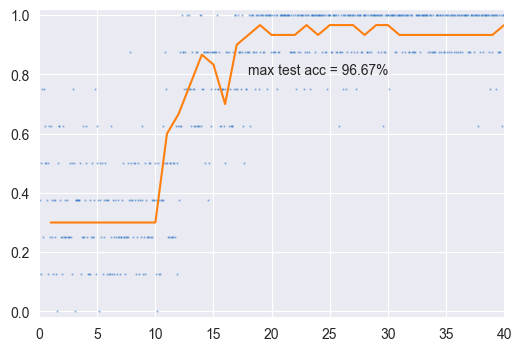

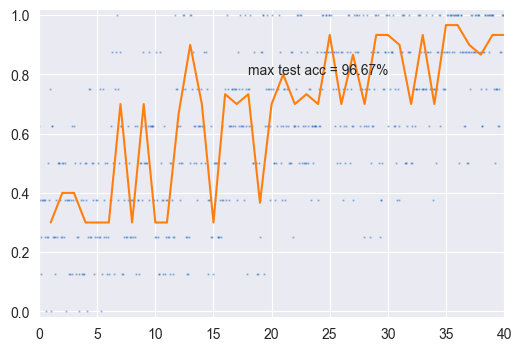

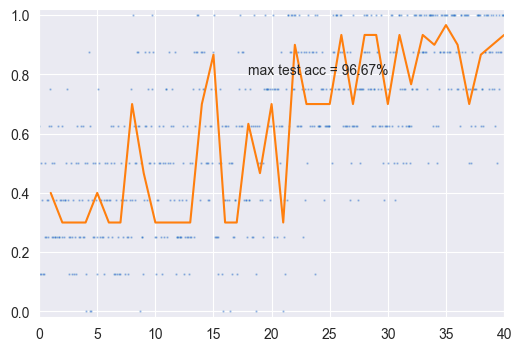

In [8]:
iris_models = [
    create_model("linear_relu", num_features=4, num_classes=3).to(device),
    create_model("linear_maxplus", num_features=4, num_classes=3).to(device),
    create_model("linear_minplus", num_features=4, num_classes=3).to(device),
]

for model in iris_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} trainable parameters")

loss = nn.CrossEntropyLoss()
epochs = 40

for model in iris_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(iris_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(iris_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(iris_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        iris_train_loader,
        iris_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [9]:
linear_accs = []
maxplus_accs = []
minplus_accs = []

for i in range(100):
    print(i)
    iris_models = [
        create_model("linear_relu", num_features=4, num_classes=3).to(device),
        create_model("linear_maxplus", num_features=4, num_classes=3).to(device),
        create_model("linear_minplus", num_features=4, num_classes=3).to(device),
    ]
    
    loss = nn.CrossEntropyLoss()
    epochs = 40
    
    for model in iris_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(iris_train),
                epochs=epochs,
            )
            
            linear_accs.append(
                train(
                    model,
                    device,
                    iris_train_loader,
                    iris_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(iris_train),
                epochs=epochs,
            )
            
            maxplus_accs.append(
                train(
                    model,
                    device,
                    iris_train_loader,
                    iris_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(iris_train),
                epochs=epochs,
            )
            
            minplus_accs.append(
                train(
                    model,
                    device,
                    iris_train_loader,
                    iris_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")
        
    display.clear_output(wait=True)
        
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0.9666666666666667
[0.9666666666666667, 0.9666666666666667, 0.9666666666666667]
0.9666666666666667
-----
0.9333333333333333
[0.9333333333333333, 0.9666666666666667, 0.9666666666666667]
0.9666666666666667
-----
0.9333333333333333
[0.9333333333333333, 0.9666666666666667, 0.9666666666666667]
0.9666666666666667


linear/relu model has 1072 trainable parameters
linear/maxplus model has 1072 trainable parameters
linear/minplus model has 1072 trainable parameters


''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

''

  0%|          | 0/40 [00:00<?, ?it/s]

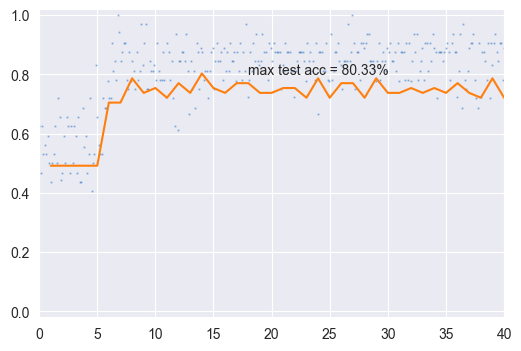

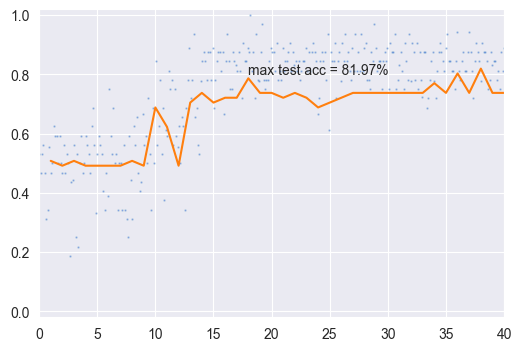

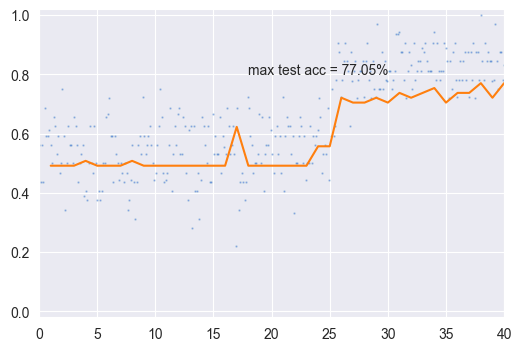

In [10]:
heart_models = [
    create_model("linear_relu", num_features=13, num_classes=2, num_layers=2).to(device),
    create_model("linear_maxplus", num_features=13, num_classes=2, num_layers=2).to(device),
    create_model("linear_minplus", num_features=13, num_classes=2, num_layers=2).to(device),
]

for model in heart_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} trainable parameters")

loss = nn.CrossEntropyLoss()
epochs = 40

for model in heart_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=6e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=6e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(heart_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(heart_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(heart_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        heart_train_loader,
        heart_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [11]:
linear_accs = []
maxplus_accs = []
minplus_accs = []

for i in range(100):
    print(i)
    
    heart_models = [
        create_model("linear_relu", num_features=13, num_classes=2, num_layers=2).to(device),
        create_model("linear_maxplus", num_features=13, num_classes=2, num_layers=2).to(device),
        create_model("linear_minplus", num_features=13, num_classes=2, num_layers=2).to(device),
    ]
    
    loss = nn.CrossEntropyLoss()
    epochs = 40
    
    for model in heart_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=6e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=6e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(heart_train),
                epochs=epochs,
            )
            
            linear_accs.append(
                train(
                    model,
                    device,
                    heart_train_loader,
                    heart_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(heart_train),
                epochs=epochs,
            )
            
            maxplus_accs.append(
                train(
                    model,
                    device,
                    heart_train_loader,
                    heart_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(heart_train),
                epochs=epochs,
            )
            
            minplus_accs.append(
                train(
                    model,
                    device,
                    heart_train_loader,
                    heart_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")
        
    display.clear_output(wait=True)
        
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0.5081967213114754
[0.8032786885245902, 0.8032786885245902, 0.819672131147541]
0.8360655737704918
-----
0.7540983606557377
[0.7868852459016393, 0.7868852459016393, 0.8032786885245902]
0.8360655737704918
-----
0.7540983606557377
[0.7868852459016393, 0.7868852459016393, 0.8032786885245902]
0.819672131147541


linear/relu model has 256 parameters
linear/maxplus model has 256 parameters
linear/minplus model has 256 parameters


''

  0%|          | 0/15 [00:00<?, ?it/s]

''

  0%|          | 0/15 [00:00<?, ?it/s]

''

  0%|          | 0/15 [00:00<?, ?it/s]

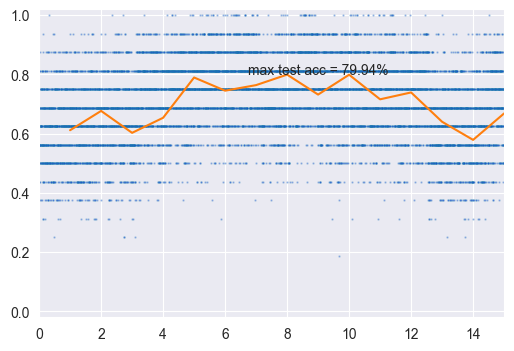

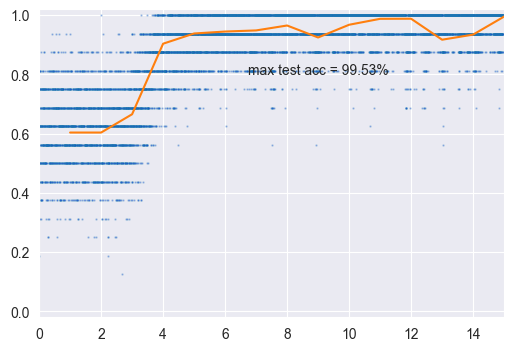

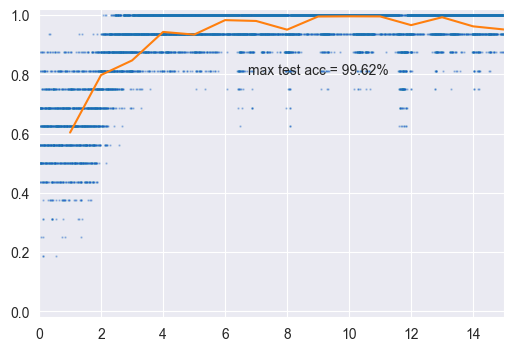

In [12]:
circles_models = [
    create_model("linear_relu", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_maxplus", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_minplus", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
]

for model in circles_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} parameters")

loss = nn.CrossEntropyLoss()
epochs = 15

for model in circles_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=6e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=6e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(circles_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(circles_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(circles_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        circles_train_loader,
        circles_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [8]:
linear_accs = []
maxplus_accs = []
minplus_accs = []

for i in range(100):
    print(i)
    
    circles_models = [
        create_model("linear_relu", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_maxplus", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_minplus", num_features=2, num_classes=2, channel_size=8, num_layers=2).to(device),
    ]
    
    loss = nn.CrossEntropyLoss()
    epochs = 15
    
    for model in circles_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=6e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=6e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(circles_train),
                epochs=epochs,
            )
            
            linear_accs.append(
                train(
                    model,
                    device,
                    circles_train_loader,
                    circles_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(circles_train),
                epochs=epochs,
            )
            
            maxplus_accs.append(
                train(
                    model,
                    device,
                    circles_train_loader,
                    circles_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(circles_train),
                epochs=epochs,
            )
            
            minplus_accs.append(
                train(
                    model,
                    device,
                    circles_train_loader,
                    circles_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")
        
    display.clear_output(wait=True)
        
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

0.616614420062696
[0.7498432601880878, 0.8347962382445141, 0.9019592476489028]
0.9893416927899686
-----
0.7648902821316614
[0.9554858934169279, 0.9901253918495297, 0.9971786833855799]
1.0
-----
0.8
[0.9643416927899686, 0.9884012539184953, 0.9971786833855799]
1.0


linear/relu model has 264 parameters
linear/maxplus model has 264 parameters
linear/minplus model has 264 parameters


''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

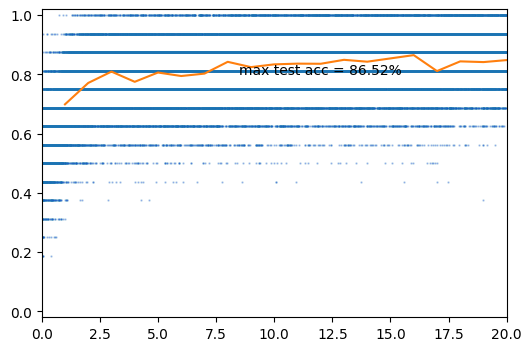

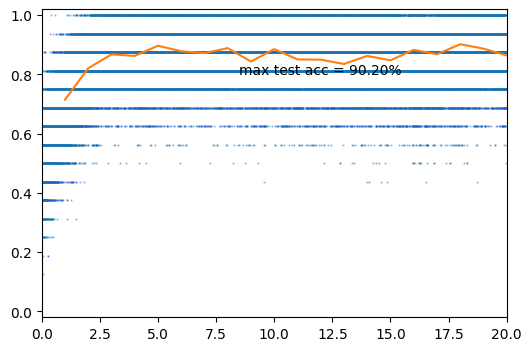

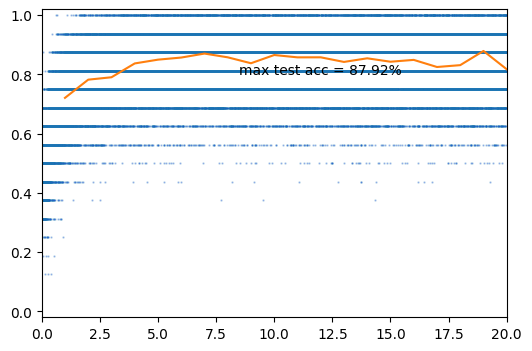

In [9]:
rings_models = [
    create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
]

for model in rings_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} parameters")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in rings_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=4e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=4e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(rings_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(rings_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(rings_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        rings_train_loader,
        rings_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [10]:
linear_accs = []
maxplus_accs = []
minplus_accs = []

for i in range(100):
    print(i)
    
    rings_models = [
        create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    ]
    
    loss = nn.CrossEntropyLoss()
    epochs = 20
    
    for model in rings_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=4e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=4e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(rings_train),
                epochs=epochs,
            )
            
            linear_accs.append(
                train(
                    model,
                    device,
                    rings_train_loader,
                    rings_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(rings_train),
                epochs=epochs,
            )

            maxplus_accs.append(
                train(
                    model,
                    device,
                    rings_train_loader,
                    rings_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(rings_train),
                epochs=epochs,
            )
            
            minplus_accs.append(
                train(
                    model,
                    device,
                    rings_train_loader,
                    rings_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")
        
    display.clear_output(wait=True)
        
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0.5015555555555555
[0.8300833333333333, 0.865, 0.8875833333333334]
0.924
-----
0.8315555555555556
[0.8851666666666668, 0.8972777777777778, 0.9099444444444446]
0.946
-----
0.8222222222222222
[0.8878888888888888, 0.8985555555555556, 0.9099722222222222]
0.9435555555555556


linear/relu model has 264 parameters
linear/maxplus model has 264 parameters
linear/minplus model has 264 parameters


''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

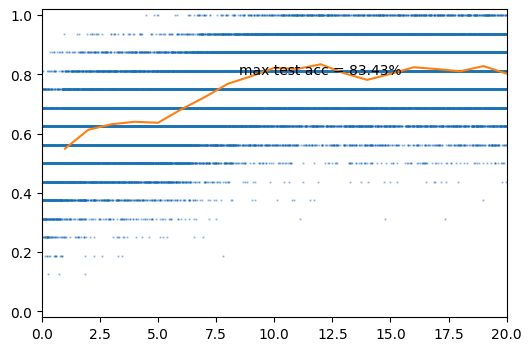

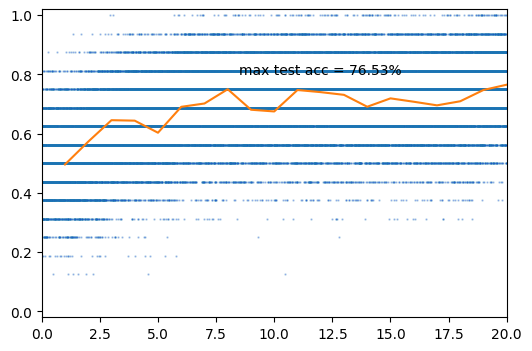

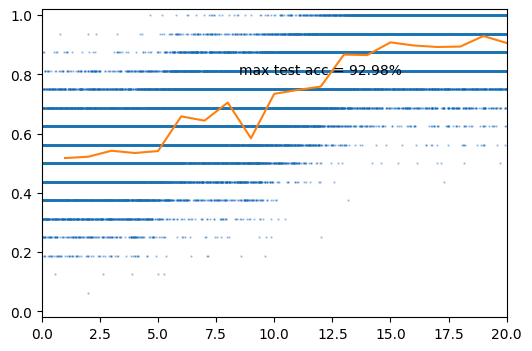

In [11]:
spheres_models = [
    create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
]

for model in rings_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} parameters")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in spheres_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(spheres_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(spheres_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(spheres_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        spheres_train_loader,
        spheres_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [ ]:
linear_accs = []
maxplus_accs = []
minplus_accs = []

for i in range(100):
    print(i)
    
    spheres_models = [
        create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
        create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2).to(device),
    ]
    
    loss = nn.CrossEntropyLoss()
    epochs = 20
    
    for model in spheres_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(spheres_train),
                epochs=epochs,
            )
            
            linear_accs.append(
                train(
                    model,
                    device,
                    spheres_train_loader,
                    spheres_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(spheres_train),
                epochs=epochs,
            )

            maxplus_accs.append(
                train(
                    model,
                    device,
                    spheres_train_loader,
                    spheres_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(spheres_train),
                epochs=epochs,
            )
            
            minplus_accs.append(
                train(
                    model,
                    device,
                    spheres_train_loader,
                    spheres_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")
        
    display.clear_output(wait=True)
        
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))

## Without proper initialisations

In [ ]:
iris_models = [
    create_model("linear_relu", num_features=4, num_classes=3, use_good_init=False).to(device),
    create_model("linear_maxplus", num_features=4, num_classes=3, use_good_init=False).to(device),
    create_model("linear_minplus", num_features=4, num_classes=3, use_good_init=False).to(device),
]

for model in iris_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} trainable parameters")

loss = nn.CrossEntropyLoss()
epochs = 40

for model in iris_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(iris_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(iris_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(iris_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        iris_train_loader,
        iris_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [ ]:
linear_accs = []
maxplus_accs = []
minplus_accs = []

for i in range(100):
    print(i)
    
    iris_models = [
        create_model("linear_relu", num_features=4, num_classes=3, use_good_init=False).to(device),
        create_model("linear_maxplus", num_features=4, num_classes=3, use_good_init=False).to(device),
        create_model("linear_minplus", num_features=4, num_classes=3, use_good_init=False).to(device),
    ]
    
    loss = nn.CrossEntropyLoss()
    epochs = 40
    
    for model in iris_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(iris_train),
                epochs=epochs,
            )
            
            linear_accs.append(
                train(
                    model,
                    device,
                    iris_train_loader,
                    iris_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(iris_train),
                epochs=epochs,
            )
            
            maxplus_accs.append(
                train(
                    model,
                    device,
                    iris_train_loader,
                    iris_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(iris_train),
                epochs=epochs,
            )
            
            minplus_accs.append(
                train(
                    model,
                    device,
                    iris_train_loader,
                    iris_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")
        
    display.clear_output(wait=True)
        
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))

In [ ]:
heart_models = [
    create_model("linear_relu", num_features=13, num_classes=2, num_layers=2, use_good_init=False).to(device),
    create_model("linear_maxplus", num_features=13, num_classes=2, num_layers=2, use_good_init=False).to(device),
    create_model("linear_minplus", num_features=13, num_classes=2, num_layers=2, use_good_init=False).to(device),
]

for model in heart_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} trainable parameters")

loss = nn.CrossEntropyLoss()
epochs = 40

for model in heart_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=6e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=6e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(heart_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(heart_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(heart_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        heart_train_loader,
        heart_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [ ]:
linear_accs = []
maxplus_accs = []
minplus_accs = []

for i in range(100):
    print(i)
    
    heart_models = [
        create_model("linear_relu", num_features=13, num_classes=2, num_layers=2, use_good_init=False).to(device),
        create_model("linear_maxplus", num_features=13, num_classes=2, num_layers=2, use_good_init=False).to(device),
        create_model("linear_minplus", num_features=13, num_classes=2, num_layers=2, use_good_init=False).to(device),
    ]
    
    loss = nn.CrossEntropyLoss()
    epochs = 40
    
    for model in heart_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=6e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=6e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(heart_train),
                epochs=epochs,
            )
            
            linear_accs.append(
                train(
                    model,
                    device,
                    heart_train_loader,
                    heart_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(heart_train),
                epochs=epochs,
            )
            
            maxplus_accs.append(
                train(
                    model,
                    device,
                    heart_train_loader,
                    heart_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(heart_train),
                epochs=epochs,
            )
            
            minplus_accs.append(
                train(
                    model,
                    device,
                    heart_train_loader,
                    heart_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")
        
    display.clear_output(wait=True)
        
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))

In [ ]:
circles_models = [
    create_model("linear_relu", num_features=2, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
    create_model("linear_maxplus", num_features=2, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
    create_model("linear_minplus", num_features=2, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
]

for model in circles_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} parameters")

loss = nn.CrossEntropyLoss()
epochs = 15

for model in circles_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=6e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=6e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(circles_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(circles_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(circles_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        circles_train_loader,
        circles_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [ ]:
linear_accs = []
maxplus_accs = []
minplus_accs = []

for i in range(100):
    print(i)
    
    circles_models = [
        create_model("linear_relu", num_features=2, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
        create_model("linear_maxplus", num_features=2, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
        create_model("linear_minplus", num_features=2, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
    ]
    
    loss = nn.CrossEntropyLoss()
    epochs = 15
    
    for model in circles_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=6e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=6e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(circles_train),
                epochs=epochs,
            )
            
            linear_accs.append(
                train(
                    model,
                    device,
                    circles_train_loader,
                    circles_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(circles_train),
                epochs=epochs,
            )
            
            maxplus_accs.append(
                train(
                    model,
                    device,
                    circles_train_loader,
                    circles_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(circles_train),
                epochs=epochs,
            )
            
            minplus_accs.append(
                train(
                    model,
                    device,
                    circles_train_loader,
                    circles_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")
        
    display.clear_output(wait=True)
        
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))

In [ ]:
rings_models = [
    create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
    create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
    create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
]

for model in rings_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} parameters")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in rings_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=4e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=4e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(rings_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(rings_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=8e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(rings_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        rings_train_loader,
        rings_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [ ]:
linear_accs = []
maxplus_accs = []
minplus_accs = []

for i in range(100):
    print(i)
    
    rings_models = [
        create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
        create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
        create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
    ]
    
    loss = nn.CrossEntropyLoss()
    epochs = 20
    
    for model in rings_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=4e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=4e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(rings_train),
                epochs=epochs,
            )
            
            linear_accs.append(
                train(
                    model,
                    device,
                    rings_train_loader,
                    rings_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(rings_train),
                epochs=epochs,
            )

            maxplus_accs.append(
                train(
                    model,
                    device,
                    rings_train_loader,
                    rings_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=8e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=8e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(rings_train),
                epochs=epochs,
            )
            
            minplus_accs.append(
                train(
                    model,
                    device,
                    rings_train_loader,
                    rings_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")
        
    display.clear_output(wait=True)
        
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))

In [ ]:
spheres_models = [
    create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
    create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
    create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
]

for model in rings_models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} parameters")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in spheres_models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(spheres_train),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(spheres_train),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=2e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(spheres_train),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        spheres_train_loader,
        spheres_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs,
    )

In [ ]:
linear_accs = []
maxplus_accs = []
minplus_accs = []

for i in range(100):
    print(i)
    
    spheres_models = [
        create_model("linear_relu", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
        create_model("linear_maxplus", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
        create_model("linear_minplus", num_features=3, num_classes=2, channel_size=8, num_layers=2, use_good_init=False).to(device),
    ]
    
    loss = nn.CrossEntropyLoss()
    epochs = 20
    
    for model in spheres_models:
        if model.name == "linear_relu":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(spheres_train),
                epochs=epochs,
            )
            
            linear_accs.append(
                train(
                    model,
                    device,
                    spheres_train_loader,
                    spheres_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_maxplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(spheres_train),
                epochs=epochs,
            )

            maxplus_accs.append(
                train(
                    model,
                    device,
                    spheres_train_loader,
                    spheres_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        elif model.name == "linear_minplus":
            optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=2e-2,
                anneal_strategy="linear",
                pct_start=0.3,
                three_phase=True,
                final_div_factor=1000.0,
                div_factor=10.0,
                steps_per_epoch=len(spheres_train),
                epochs=epochs,
            )
            
            minplus_accs.append(
                train(
                    model,
                    device,
                    spheres_train_loader,
                    spheres_test_loader,
                    optimizer,
                    scheduler,
                    loss,
                    epochs,
                    statistics_mode=True
                )
            )
        else:
            raise RuntimeError(f"Unknown model ({model.name})")
        
    display.clear_output(wait=True)
        
print(min(linear_accs))
print(quantiles(linear_accs))
print(max(linear_accs))
print('-----')
print(min(maxplus_accs))
print(quantiles(maxplus_accs))
print(max(maxplus_accs))
print('-----')
print(min(minplus_accs))
print(quantiles(minplus_accs))
print(max(minplus_accs))